### Problem Description

### The Challenge
**The sinking of the Titanic is one of the most infamous shipwrecks in history.**

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build **a predictive model** that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Data Description

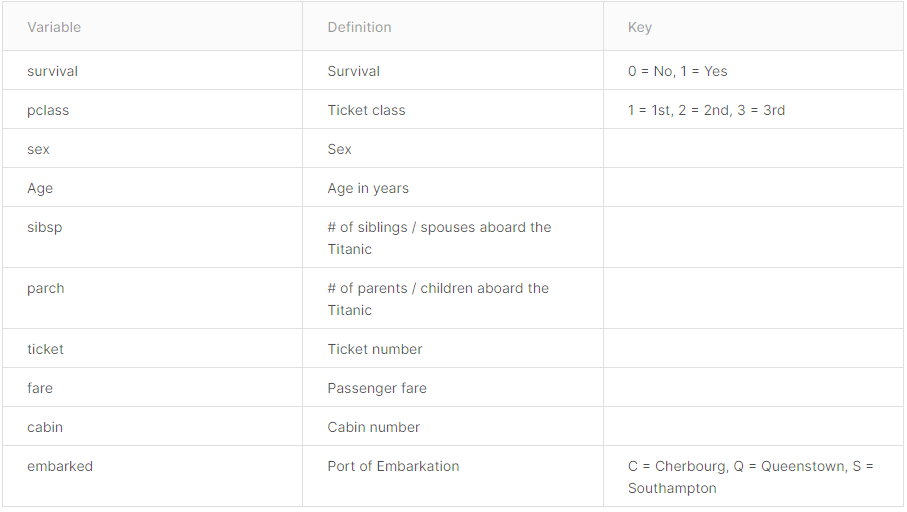


## Importing libraries

In [1]:

import pandas as pd; import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_predict
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score,accuracy_score,classification_report
from scipy.stats import norm, skew

from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
 

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.svm import SVC

import lightgbm as lgbm
import xgboost
from xgboost import  XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

from scipy.stats import boxcox
import xgboost as xgb


from scipy import stats
from scipy.stats import norm, skew

import seaborn as sns
import matplotlib.pyplot as plt  

import warnings
warnings.filterwarnings('ignore')

print('Libraries imported')

Libraries imported


In [2]:
#Reading train and test files

#links to files : https://www.kaggle.com/c/titanic/data?select=test.csv

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Exploratory Data Analysis

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
print('Object features :{}\nNumeric features :{}'.format(train.dtypes[train.dtypes==np.object].index.to_list(),
                                      train.dtypes[train.dtypes!=np.object].index.to_list()))

Object features :['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numeric features :['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
def isnull(df):
    
    tot = df.isnull().sum()
    pr = round(df.isnull().sum()/df.isnull().count()*100,1).sort_values(
                                                        ascending=False)
    
    return pd.concat([tot,pr],axis=1,keys=['Total','Percent']).sort_values(
        'Total',ascending=False).head()
            
isnull(train)

,Total,Percent
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


In [8]:
isnull(test)

,Total,Percent
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2
PassengerId,0,0.0
Pclass,0,0.0


***Distribution of features***

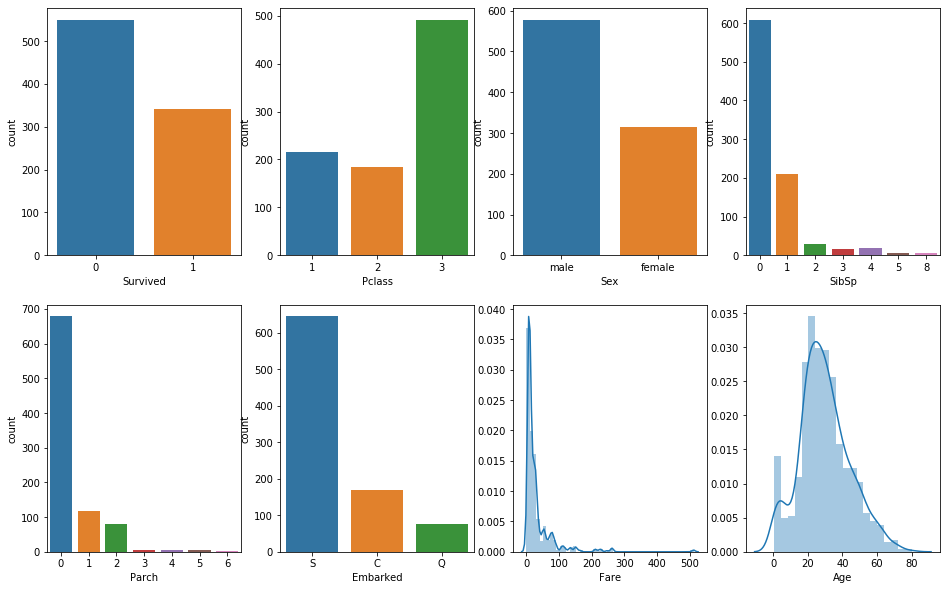

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
sns.countplot('Survived',data=train,ax=axes[0,0])
sns.countplot('Pclass',data=train,ax=axes[0,1])
sns.countplot('Sex',data=train,ax=axes[0,2])
sns.countplot('SibSp',data=train,ax=axes[0,3])
sns.countplot('Parch',data=train,ax=axes[1,0])
sns.countplot('Embarked',data=train,ax=axes[1,1])
sns.distplot(train['Fare'], kde=True,ax=axes[1,2])
sns.distplot(train['Age'].dropna(),kde=True,ax=axes[1,3])

**Sex and Survived**

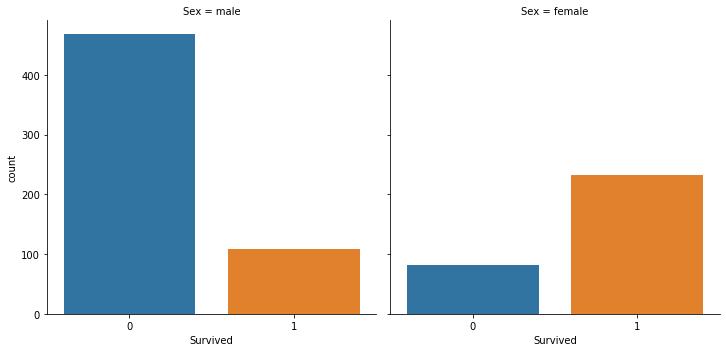

In [10]:
sns.factorplot(x='Survived',col='Sex',kind='count',data=train)
plt.show()

Here we can see that women were more likly to be survived than men

**Pclass and Survived**

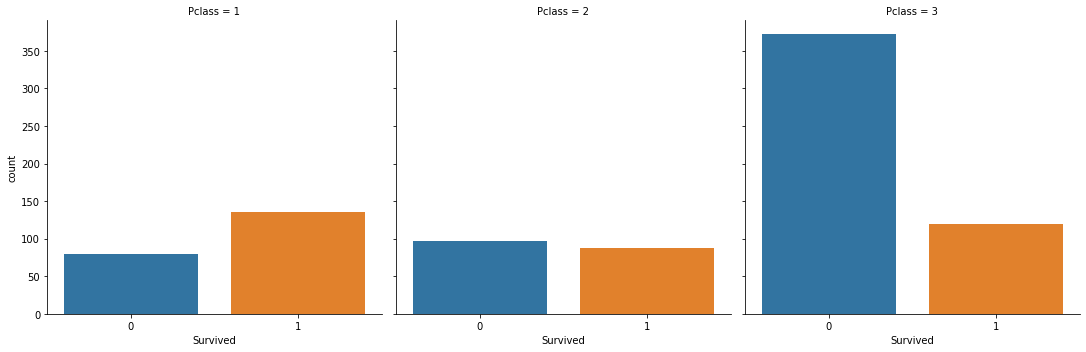

In [11]:
sns.factorplot(x='Survived',col='Pclass',kind='count',data=train)
plt.show()

People in the first class are more likely to survive while class 2 and 3 have more died people than survived which make sense ,rich people had more chance to survive in the titanic disaster

**SibSp and Parch**

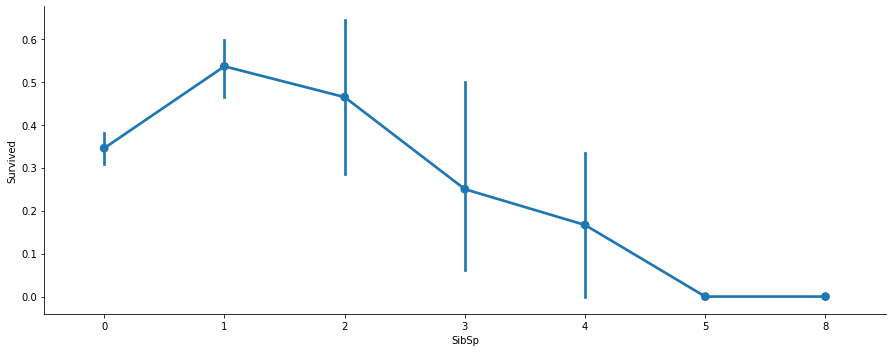

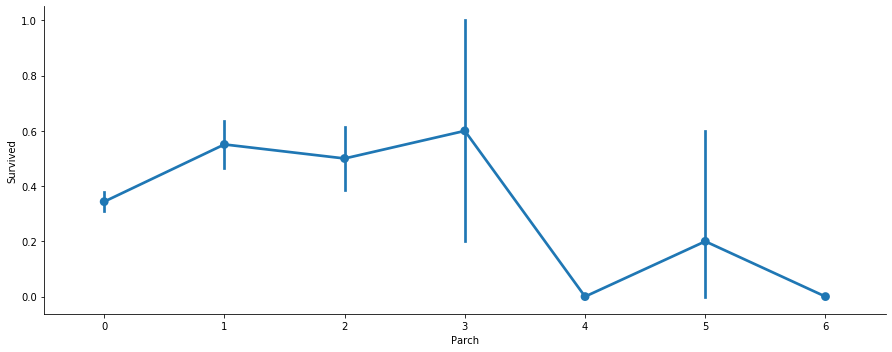

In [12]:
axes = sns.factorplot('SibSp','Survived', 
                      data=train, aspect = 2.5, )

axes = sns.factorplot('Parch','Survived', 
                      data=train, aspect = 2.5, )

**Pclass and Sex**

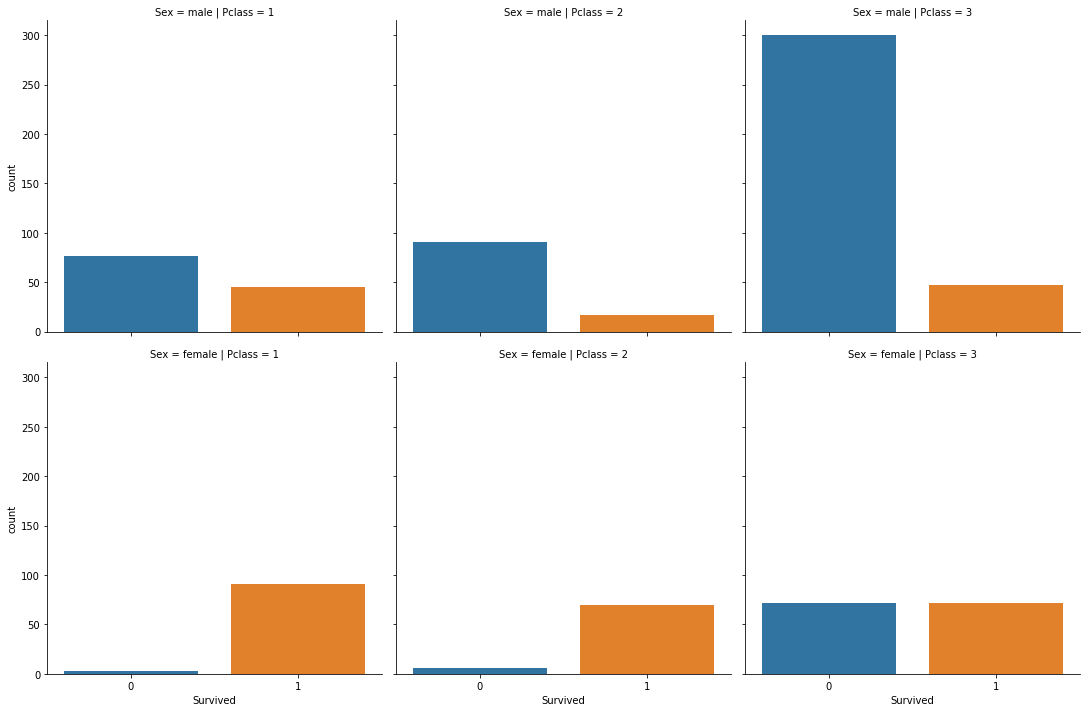

In [13]:
sns.factorplot(x='Survived',col='Pclass',kind='count',row='Sex',data=train)
plt.show()

**Embarked , Pclass and Sex**

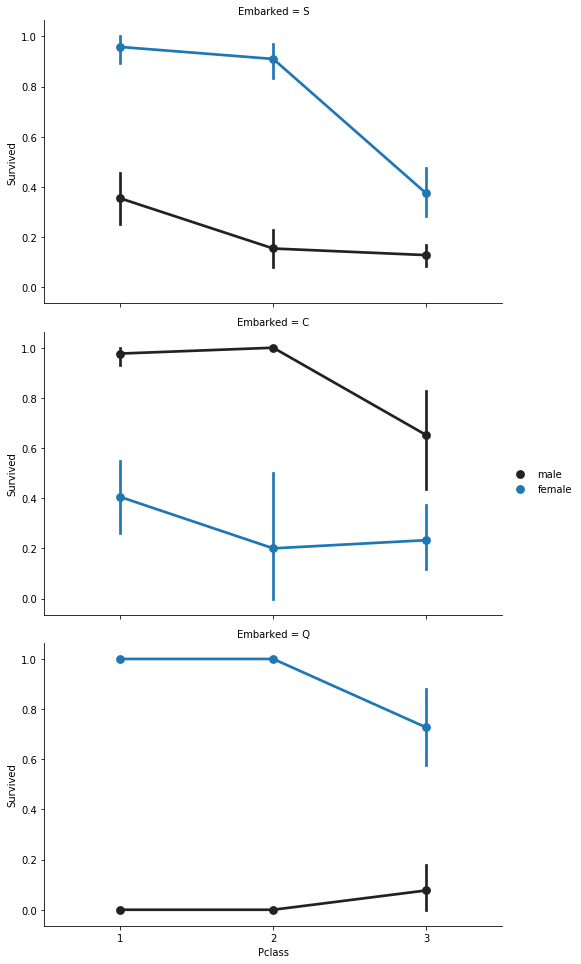

In [14]:
FacetGrid = sns.FacetGrid(train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()


Women on the port S and Q had more chance to survived while in the C port most of men survived no matter which class they belong

## Data Preprocessing

I will create some functions for prerocessing steps for both train and test data

In [15]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
def del_cols(df):
    df.drop(['PassengerId','Ticket'],axis=1,inplace=True)
    return df


del_cols(train)

del_cols(test)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,NaN,S
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C105,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,NaN,S


In [17]:
def name(df):
    name = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
    name.replace(['Miss','Mrs','Lady','Ms','Mme','Mlle','the Countess'],'Mrs',inplace=True)
    name.replace('Sir','Mr',inplace=True)
    name.replace(['Capt','Don','Dona','Jonkheer','Rev','Dr','Major','Col'],'Others',inplace=True)
    df['Name'] = name
    return df

name(train)
name(test)



,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,Mr,male,34.5,0,0,7.8292,NaN,Q
1,3,Mrs,female,47.0,1,0,7.0000,NaN,S
2,2,Mr,male,62.0,0,0,9.6875,NaN,Q
3,3,Mr,male,27.0,0,0,8.6625,NaN,S
4,3,Mrs,female,22.0,1,1,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...
413,3,Mr,male,NaN,0,0,8.0500,NaN,S
414,1,Others,female,39.0,0,0,108.9000,C105,C
415,3,Mr,male,38.5,0,0,7.2500,NaN,S
416,3,Mr,male,NaN,0,0,8.0500,NaN,S


In [18]:
def Gender(df):
    genders = {"male": 0, "female": 1}
    df['Sex'] = df['Sex'].map(genders)
    
Gender(train)
Gender(test)

In [19]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,Mr,0,22.0,1,0,7.2500,NaN,S
1,1,1,Mrs,1,38.0,1,0,71.2833,C85,C
2,1,3,Mrs,1,26.0,0,0,7.9250,NaN,S
3,1,1,Mrs,1,35.0,1,0,53.1000,C123,S
4,0,3,Mr,0,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,Others,0,27.0,0,0,13.0000,NaN,S
887,1,1,Mrs,1,19.0,0,0,30.0000,B42,S
888,0,3,Mrs,1,NaN,1,2,23.4500,NaN,S
889,1,1,Mr,0,26.0,0,0,30.0000,C148,C


In [20]:
def Age(df):
    mean = df["Age"].mean()
    std = df["Age"].std()
    is_null = df["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = df["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    df["Age"] = age_slice
    df["Age"] = df["Age"].astype(int)
    
    '''df.loc[df['Age'] <= 11, 'Age'] = 0
    df.loc[(df['Age'] > 11) & (df['Age'] <= 18), 'Age'] = 1
    df.loc[(df['Age'] > 18) & (df['Age'] <= 22), 'Age'] = 2
    df.loc[(df['Age'] > 22) & (df['Age'] <= 27), 'Age'] = 3
    df.loc[(df['Age'] > 27) & (df['Age'] <= 33), 'Age'] = 4
    df.loc[(df['Age'] > 33) & (df['Age'] <= 40), 'Age'] = 5
    df.loc[(df['Age'] > 40) & (df['Age'] <= 66), 'Age'] = 6
    df.loc[df['Age'] > 66, 'Age'] = 6'''
    
Age(train)
Age(test)

In [21]:
def Embarked(df):
    df['Embarked'] = df['Embarked'].replace(np.nan,'S')
    '''ports = {"S": 0, "C": 1, "Q": 2}
    df['Embarked'] = df['Embarked'].map(ports)'''


Embarked(train)
Embarked(test)

In [22]:
def Relatives(df):
    df['relatives'] = df['SibSp'] + df['Parch']
    '''df.loc[df['relatives'] > 0, 'not_alone'] = 0
    df.loc[df['relatives'] == 0, 'not_alone'] = 1
    df['not_alone'] = df['not_alone'].astype(int)'''
    
Relatives(train)
Relatives(test)

In [23]:
def Fare(df):
    df['Fare'] = df['Fare'].replace(np.nan,0)
    #df['Fare'] = pd.qcut(df['Fare'],5,labels=[0,1,2,3,4])

Fare(train)
Fare(test)

In [24]:
def Cabin(df):
    df['Cabin'] = df.Cabin.str.extract(r'\b(\w)', expand=True)
    df['Cabin'] = df.Cabin.replace(['A','B','C','D','E','F','G',np.nan,],
                                   [1,2,3,4,5,6,7,8])
    
    train.drop(train.Cabin.index[339],inplace=True)
    #train = train.reset_index().drop('index',axis=1)
    df['Cabin'] = df['Cabin'].astype(int)
    
    return df

Cabin(train)
Cabin(test)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,relatives
0,3,Mr,0,34,0,0,7.8292,8,Q,0
1,3,Mrs,1,47,1,0,7.0000,8,S,1
2,2,Mr,0,62,0,0,9.6875,8,Q,0
3,3,Mr,0,27,0,0,8.6625,8,S,0
4,3,Mrs,1,22,1,1,12.2875,8,S,2
...,...,...,...,...,...,...,...,...,...,...
413,3,Mr,0,32,0,0,8.0500,8,S,0
414,1,Others,1,39,0,0,108.9000,3,C,0
415,3,Mr,0,38,0,0,7.2500,8,S,0
416,3,Mr,0,23,0,0,8.0500,8,S,0


In [25]:
train.isnull().sum()

Survived     0
Pclass       0
Name         0
Sex          0
Age          0
SibSp        0
Parch        0
Fare         0
Cabin        0
Embarked     0
relatives    0
dtype: int64

In [26]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,relatives
0,0,3,Mr,0,22,1,0,7.2500,8,S,1
1,1,1,Mrs,1,38,1,0,71.2833,3,C,1
2,1,3,Mrs,1,26,0,0,7.9250,8,S,0
3,1,1,Mrs,1,35,1,0,53.1000,3,S,1
4,0,3,Mr,0,35,0,0,8.0500,8,S,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,Others,0,27,0,0,13.0000,8,S,0
887,1,1,Mrs,1,19,0,0,30.0000,2,S,0
888,0,3,Mrs,1,34,1,2,23.4500,8,S,3
889,1,1,Mr,0,26,0,0,30.0000,3,C,0


In [27]:
train = pd.get_dummies(train,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

## Model Bulding

In [28]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [29]:
def accuracy(X,y,model): #The function for accuracy metrics
    f1 =f1_score(y,model.predict(X))
    roc = roc_auc_score(y,model.predict(X))
    a_s =accuracy_score(y,model.predict(X))
    ac = pd.DataFrame({'Accuracy':[f1,roc,a_s]},index=['F1','ROC','Acc Sc'])
    return ac
    
def conf_matrix(X,y,model):
    return pd.DataFrame(confusion_matrix(y,model.predict(X)))


def score(X_train,X_test,
          y_train,y_test,
          model):
    print('Train score',accuracy(X_train,y_train,model))
    print('Test score',accuracy(X_test,y_test,model))
   


In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
data = train.reset_index().drop('index',axis=1)

target = 'Survived'

feature_cols = [x for x in data.columns if x != target]

# Split the data into two parts with 178 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=178, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data[target]))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, target]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, target]

In [31]:
scale = MinMaxScaler()
X_train[['Age','Fare']] = scale.fit_transform(X_train[['Age','Fare']])
X_test[['Age','Fare']] = scale.transform(X_test[['Age','Fare']])
test[['Age','Fare']] = scale.transform(test[['Age','Fare']])


### Logistic Regression with GridSearch

In [ ]:
estimator = Pipeline([
        ("log_regression", LogisticRegression())])

params = {
    'log_regression__max_iter': [10,25,50,100,500],
    'log_regression__penalty':['l1','l2'],
    'log_regression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'log_regression__C':np.geomspace(0.001,10,100)
}

log_grid = GridSearchCV(estimator, params, cv=5,return_train_score=True)
log_grid.fit(X_train,y_train)
print("Best score --",log_grid.best_score_)
print("Parameters --",log_grid.best_params_)

In [ ]:
score(X_train,X_test,
          y_train,y_test,
          log_grid)

### Support Vector Classifier

In [ ]:
svc = SVC(C = 0.597,gamma=0.02)
svc.fit(X_train,y_train)
score(X_train,X_test,
          y_train,y_test,
          svc)

In [ ]:
svc = SVC(C = 0.1,kernel='linear')
svc.fit(X_train,y_train)
score(X_train,X_test,
          y_train,y_test,
          svc)

Still not good

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


max_k = 40
acc = list()


for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    test_sc = accuracy_score(y_test,y_pred)
    train_sc = accuracy_score(y_train, knn.predict(X_train))
   
    acc.append(pd.Series({'N_K': k, 'Test': test_sc,'Train':train_sc}))
    

rf_oob_df = pd.concat(acc, axis=1).T.set_index('N_K')

rf_oob_df

### RandomForestClassifier

In [ ]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1,
                            max_depth=4,
                            
                            
                         )

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = accuracy_score(y_test,RF.predict(X_test)) 
    obb_train = accuracy_score(y_train,RF.predict(X_train)) 
    # Store it
    oob_list.append(pd.Series({'N_trees': n_trees, 'Test': oob_error,'Train':obb_train}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('N_trees')

rf_oob_df

### ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1,
                          max_depth=4
                )

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400,500,1000]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    
    oob_error = accuracy_score(y_test,RF.predict(X_test)) 
    obb_train = accuracy_score(y_train,RF.predict(X_train)) 
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'test': oob_error,'train':obb_train}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

### GradientBoostingClassifier

In [ ]:
### BEGIN SOLUTION
from sklearn.ensemble import GradientBoostingClassifier

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25,30,40, 50, 100, 200, 400,500,1000]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42,
                                    max_depth=4,learning_rate=0.02)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train, y_train)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = accuracy_score(y_test, y_pred)
    error2 = accuracy_score(y_train, GBC.predict(X_train))
    
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'test': error,'train':error2}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

### XGBClassifier

In [ ]:
'''xg = XGBClassifier(learning_rate=0.001,n_estimators=50,
                  max_depth=4)
xg.fit(X_train,y_train)
score(X_train,X_test,
          y_train,y_test,
          xg)'''


error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25,30,40, 50, 100, 200, 400,500,1000]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    xg = XGBClassifier(n_estimators=n_trees, random_state=42,
                                    max_depth=3,learning_rate=0.01,
                      verbosity=0)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    xg.fit(X_train, y_train)
    y_pred = xg.predict(X_test)

    # Get the error
    error = accuracy_score(y_test, y_pred)
    error2 = accuracy_score(y_train, xg.predict(X_train))
    
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'test': error,'train':error2}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

### CatBoostClassifier

In [ ]:
from catboost import CatBoostClassifier
# Initialize data


# Initialize CatBoostRegressor
'''cat = CatBoostClassifier(n_estimators=100,
                          learning_rate=0.009
                           ,
                          verbose=0,
                          max_depth=3
                           
                         )
# Fit model
cat.fit(X_train, y_train)
# Get predictions
score(X_train,X_test,
          y_train,y_test,
          cat)'''



error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25,30,40, 50, 100, 200, 400,500,1000]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    cat = CatBoostClassifier(n_estimators=n_trees, random_state=42,
                                    max_depth=3,learning_rate=0.001,
                      verbose=0)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    cat.fit(X_train, y_train)
    y_pred = cat.predict(X_test)

    # Get the error
    error = accuracy_score(y_test, y_pred)
    error2 = accuracy_score(y_train, cat.predict(X_train))
    
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'test': error,'train':error2}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Catboost feature importance

In [ ]:
pd.DataFrame(data={'Score':cat.feature_importances_,'Feat':X_train.columns}).sort_values('Score',ascending=False)

**Among all models , the best ones are LogisticRegression and SVC , though others have higher score, they have overfitting problems**

In [ ]:
log_grid.predict(test)

In [ ]:

t_id = pd.read_csv('test.csv')['PassengerId']
cs = pd.DataFrame(data={'PassengerId': t_id, 'Survived': svc.predict(test)})
cs.to_csv("titanic_model1.csv",index=False)

cs

In [ ]:
cs['Survived'].value_counts()